In [545]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

import graphviz

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Problem Statement

A financial metric that is popular in breaking down the return on equity (ROE) of a company is called the Dupont Analysis.  The Dupont Analysis breaks down the ROE into three components - profit margin X asset turnover X leverage.

First Community Bank, a publicly traded company with the ticker FCBC, generated a return on equity of 11.23% in 2023.  The average return on equity for all banks over time is approximately 12%.  

The questions I would like to answer are:

1.  Which ratios of the Dupont Analysis were the greatest predictor of a company generating an ROE greater than 12%?
2.  What does the data suggest are areas of opportunity for improving profitability, specifically through efficiency?

A decision tree, logistic regression, and support vector classifier were ran to identify the best model for prediction.  Decision trees were viewed as well to get an idea as to the characteristics of banks with higher profitability.

Answering this question is important as it will allow the bank to focus on ways to improve the profitability of the bank and help direct future strategy.


## Data for Analysis

A 3rd party database (S&P Capital IQ) that contains hundreds of financial metrics for banks across the world is used to build the dataset. The dataset being used contains only banks located in the United States.  The number of banks in the dataset is 4,549.  The file name is 2023Y_Bank_Regulatory_Financials.xlsx   

The data in the analysis is all public information and there are no confidentiality concerns.

https://www.capitaliq.spglobal.com

## Loading, Merging and Preprocessing Data

The excel file containing bank ratios contains 3 tabs of information that are then merged into a single dataframe.  Once merged, the data distribution of each feature is analyzed.  In addition, outliers are being excluded by removing any that have a z-score of 3.25 or greater.  Rows and columns that contain a higher percentage of null values are excluded.  Created additional features helpful for the prediction.  Using a z-score of 3.25, the number of rows in the data file is reduced to 3,033.  Rows with significant null values were removed.  In addition, onehotencoding was ran on categorical features.

In [546]:
file_path = '2023Y_Bank_Regulatory_Financials.xlsx'

In [547]:
# Reading Company_List Tab

df_company = pd.read_excel(file_path, sheet_name='Company_List', header=3, skiprows=range(4, 7))

print(df_company.columns)

df_company.query('`SNL Institution Key ` == 1024885')

Index(['Company Name ', 'SNL Institution Key ', 'City ', 'State ',
       'Regulatory ID ', 'Ownership Structure ', 'Year Established ',
       'De Novo Bank? Yes/No', 'Number of Offices (actual)',
       'Primary Regulator ', 'Public Ownership ',
       'Merger Target or MOE Participant? Yes/No', 'Total Assets ($000)',
       'Asset Growth Rate (%)', 'Loan Growth Rate (%)',
       'Deposit Growth Rate (%)', 'Memo: Full-time Employees (actual)'],
      dtype='object')


,Company Name,SNL Institution Key,City,State,Regulatory ID,Ownership Structure,Year Established,De Novo Bank? Yes/No,Number of Offices (actual),Primary Regulator,Public Ownership,Merger Target or MOE Participant? Yes/No,Total Assets ($000),Asset Growth Rate (%),Loan Growth Rate (%),Deposit Growth Rate (%),Memo: Full-time Employees (actual)
1563,First Community Bank,1024885,Bluefield,VA,2353595.0,Stock Corporation,1920.0,No,58.0,FED,Sub of Major Exchange Instn,No,3241163.0,4.13,7.17,1.53,613.0


In [548]:
# Reading Dupont_Data Tab

df_ratios = pd.read_excel(file_path, sheet_name='Dupont_Data', header=4, skiprows=range(5, 8))

# print(df_ratios.columns)

# Converting NaN values to 0

for column in df_ratios.select_dtypes(include=['object']).columns:
        df_ratios[column] = pd.to_numeric(df_ratios[column], errors='coerce')
        
# Dropping Company Name

df_ratios.drop('Company Name', axis=1, inplace=True)

df_ratios.query('`Institution_Key` == 1024885')



,Institution_Key,ROAE (%),ROAA (%),Avg Assets/ Avg Equity (x),Net Interest Income/ Avg Assets (%),Noninterest Income/ Average Assets (%),Noninterest Expense/ Avg Assets (%),Gain on Securities/ Avg Assets (%),Provision Expense/ Avg Assets (%),Income Tax/ Avg Assets (%),After-tax Items/ Avg Assets (%),Net Interest Margin (%),Avg Earning Assets/ Avg Assets (%),Yield/ Cost Spread (%),Gain on Net Int Position/ Avg EA (%),Yield on Earning Assets (%),Nonint-bear Dep/ Deposits (%),MMDAs+Savings/ Deposits (%),IRA & Keogh Plan/ Deposits (%),Retail Time Dep/ Deposits (%),Jumbo Time Deposits/ Deposits (%),Cost of Interest-bearing Liabilities (%),Net Interest Position/ Avg EA (%),Asset-weighted Loan Yield (%),Asset-weighted Securities Yield (%),Asset-weighted Other Asset Yield (%),Liab-weigh Cost of Int-bear Dep (%),Liability-wtd Borrowing Cost (%),DOM: Construction & Land Development Loans/ Loans (%),DOM: Farm Loans/ Loans (%),DOM: Revolving 1-4 Family Loans/ Loans (%),DOM: Closed-end 1-4 Family Loans/ Loans (%),DOM: Multifamily Loans/ Loans (%),DOM: CommRE(Nfarm/NRes)/ Loans (%),Yield on Loans and Leases (%),Avg Loans/ Avg Earning Assets (%),Yield on Debt and Equity Securities (%),Avg Securities/ Avg Earning Assets (%),Yield on Other Assets (%),Premises & Fixed Assets/ Assets (%),Total Intangible Assets/ Assets (%),Avg Other Assets/ Avg EA (%),Cost of Int-bearing Deposits (%),Avg Int-bear Deps/ Avg Int-bear Liab (%),Cost of Borrowings (%),Avg Borrowing/ Avg Int-bear Liab (%),NII: Fiduciary Activities/ Avg Assets (%),"NII: Inv Bkg, Advsry, &Oth/ Avg Assets (%)",NII: Venture Capital Revenue/ Avg Assets (%),NII: Tot Trading Revenue/ Avg Assets (%),Gain on Asset Sales/ Avg Assets (%),NII: Net Gains Lns & Lses/ Avg Assets (%),NII: Net Gains on OREO/ Avg Assets (%),NII: Net Gns on Oth Assts/ Avg Assets (%),NII: Net Servicing Fees/ Avg Assets (%),NII: Net Securitization Income/ Avg Assets (%),NII: Services Chrgs on Deps/ Avg Assets (%),NII: Ins Commissions & Fees/ Avg Assets (%),NII: Other Insurance Income/ Avg Assets (%),NII: Ins & ReIns Undrwrtg Inc/ Avg Assets (%),NII: Other Noninterest Inc/ Avg Assets (%),Salary Expense/ Avg Assets (%),NIE: Occup & Fixed Asset/ Avg Assets (%),NIE: Amortization of Intang/ Avg Assets (%),Other Noninterest Exp/ Avg Assets (%),Loans/ Deposits (%),Operating Expense/ Operating Revenue (%),Earning Assets/ IBL (%),Brokered Deposits/ Deposits (%),Total: Intangibles/ Equity Capital (%),Equity Capital/ Avg Assets (%)
1563,1024885,11.23,1.48,7.57,3.92,1.22,2.98,0.0,0.26,0.43,0.0,4.4,89.04,4.2,0.2,4.7347,34.05,55.52,0.9204,8.55,0.68,0.53,37.08,4.3903,0.2331,0.1113,0.52,0.01,4.45,0.55,3.41,35.81,7.32,33.94,4.99,87.91,2.3164,10.07,5.51,1.56,4.91,2.02,0.52,99.92,9.76,0.08,0.07,0.06,NaN,NaN,0.02,0.0,0.0,0.02,0.0,NaN,0.43,0.0,NaN,NaN,0.65,1.53,0.34,0.05,1.06,93.98,56.89,159.19,0.13,34.53,14.21


In [549]:
# Reading Deposit_Data Tab

df_deposit = pd.read_excel(file_path, sheet_name='Deposit_Data', header=2, skiprows=range(3, 7))


df_deposit = df_deposit.groupby(by='S&P Institution Key ', as_index=True).agg({'S.O.D. Deposits ($000)': ['sum', 'count']}).reset_index()

df_deposit.columns=['Institution Key', 'TotalBranchDeposits', 'NumberBranches']


df_deposit.query('`Institution Key` == 1024885')

,Institution Key,TotalBranchDeposits,NumberBranches
3578,1024885,2859818.0,58


In [550]:
df = df_company.merge(right=df_ratios, how='left', left_on='SNL Institution Key ', right_on='Institution_Key')
df = df.merge(right=df_deposit, how='left', left_on='SNL Institution Key ', right_on='Institution Key')
df.head(5)

,Company Name,SNL Institution Key,City,State,Regulatory ID,Ownership Structure,Year Established,De Novo Bank? Yes/No,Number of Offices (actual),Primary Regulator,Public Ownership,Merger Target or MOE Participant? Yes/No,Total Assets ($000),Asset Growth Rate (%),Loan Growth Rate (%),Deposit Growth Rate (%),Memo: Full-time Employees (actual),Institution_Key,ROAE (%),ROAA (%),Avg Assets/ Avg Equity (x),Net Interest Income/ Avg Assets (%),Noninterest Income/ Average Assets (%),Noninterest Expense/ Avg Assets (%),Gain on Securities/ Avg Assets (%),Provision Expense/ Avg Assets (%),Income Tax/ Avg Assets (%),After-tax Items/ Avg Assets (%),Net Interest Margin (%),Avg Earning Assets/ Avg Assets (%),Yield/ Cost Spread (%),Gain on Net Int Position/ Avg EA (%),Yield on Earning Assets (%),Nonint-bear Dep/ Deposits (%),MMDAs+Savings/ Deposits (%),IRA & Keogh Plan/ Deposits (%),Retail Time Dep/ Deposits (%),Jumbo Time Deposits/ Deposits (%),Cost of Interest-bearing Liabilities (%),Net Interest Position/ Avg EA (%),Asset-weighted Loan Yield (%),Asset-weighted Securities Yield (%),Asset-weighted Other Asset Yield (%),Liab-weigh Cost of Int-bear Dep (%),Liability-wtd Borrowing Cost (%),DOM: Construction & Land Development Loans/ Loans (%),DOM: Farm Loans/ Loans (%),DOM: Revolving 1-4 Family Loans/ Loans (%),DOM: Closed-end 1-4 Family Loans/ Loans (%),DOM: Multifamily Loans/ Loans (%),DOM: CommRE(Nfarm/NRes)/ Loans (%),Yield on Loans and Leases (%),Avg Loans/ Avg Earning Assets (%),Yield on Debt and Equity Securities (%),Avg Securities/ Avg Earning Assets (%),Yield on Other Assets (%),Premises & Fixed Assets/ Assets (%),Total Intangible Assets/ Assets (%),Avg Other Assets/ Avg EA (%),Cost of Int-bearing Deposits (%),Avg Int-bear Deps/ Avg Int-bear Liab (%),Cost of Borrowings (%),Avg Borrowing/ Avg Int-bear Liab (%),NII: Fiduciary Activities/ Avg Assets (%),"NII: Inv Bkg, Advsry, &Oth/ Avg Assets (%)",NII: Venture Capital Revenue/ Avg Assets (%),NII: Tot Trading Revenue/ Avg Assets (%),Gain on Asset Sales/ Avg Assets (%),NII: Net Gains Lns & Lses/ Avg Assets (%),NII: Net Gains on OREO/ Avg Assets (%),NII: Net Gns on Oth Assts/ Avg Assets (%),NII: Net Servicing Fees/ Avg Assets (%),NII: Net Securitization Income/ Avg Assets (%),NII: Services Chrgs on Deps/ Avg Assets (%),NII: Ins Commissions & Fees/ Avg Assets (%),NII: Other Insurance Income/ Avg Assets (%),NII: Ins & ReIns Undrwrtg Inc/ Avg Assets (%),NII: Other Noninterest Inc/ Avg Assets (%),Salary Expense/ Avg Assets (%),NIE: Occup & Fixed Asset/ Avg Assets (%),NIE: Amortization of Intang/ Avg Assets (%),Other Noninterest Exp/ Avg Assets (%),Loans/ Deposits (%),Operating Expense/ Operating Revenue (%),Earning Assets/ IBL (%),Brokered Deposits/ Deposits (%),Total: Intangibles/ Equity Capital (%),Equity Capital/ Avg Assets (%),Institution Key,TotalBranchDeposits,NumberBranches
0,1NB Bank,1011521,Carlyle,IL,614948.0,Stock Corporation,1878.0,No,4.0,OCC,Private,No,295806.0,3.15,7.69,-6.8,31.0,1011521,7.65,0.50,15.27,2.02,0.31,1.69,0.00,0.06,0.09,0.0,2.18,92.89,1.78,0.40,3.7579,17.56,18.87,0.8236,17.32,9.59,1.98,20.19,2.7589,0.7674,0.2316,1.69,0.29,1.21,32.11,2.14,9.94,1.89,23.83,5.23,52.79,1.8561,41.35,3.95,0.66,0.11,5.86,1.80,94.08,4.90,5.92,0.04,0.01,NaN,NaN,0.01,0.01,0.0,0.0,0.0,NaN,0.08,0.0,NaN,NaN,0.16,0.85,0.16,0.06,0.62,67.58,70.11,122.59,0.0,1.57,7.28,1011521.0,243705.0,4.0
1,1st Advantage Bank,4095211,Saint Peters,MO,3317192.0,Stock Corporation,2005.0,Yes,1.0,FDIC,Private,No,152151.0,0.5,3.43,-0.78,21.0,4095211,11.51,1.18,9.74,3.97,0.18,2.89,0.00,0.09,0.00,0.0,4.04,98.21,3.21,0.83,5.2666,30.28,26.01,1.0362,24.23,13.73,2.06,40.51,4.8092,0.0405,0.4169,1.97,0.09,3.20,1.38,1.15,8.52,3.16,66.25,5.33,90.25,3.6787,1.10,4.82,1.46,0.00,8.65,2.04,96.74,2.61,3.26,0.00,0.00,NaN,NaN,0.00,0.00,0.0,0.0,0.0,NaN,0.06,0.0,NaN,NaN,0.13,1.78,0.24,0.00,0.86,104.57,69.49,157.72,0.0,0.00,10.89,4095211.0,129432.0,1.0
2,1st Bank in Hominy,1008383,Hominy,OK,350657.0,Stock Corporation,1906.0,No,1.0,FED,Private,No,

In [551]:
# Check for duplicate values
num_dupes = df.duplicated(subset = 'SNL Institution Key ', keep=False).sum()
print(f'There are {num_dupes} duplicate values.')


There are 0 duplicate values.


In [552]:
# Viewing correlated features.

pd.DataFrame(df.corr()['ROAE (%)']).sort_values('ROAE (%)', ascending=False)

,ROAE (%)
ROAE (%),1.000000
Avg Assets/ Avg Equity (x),0.591168
ROAA (%),0.330337
NII: Net Gns on Oth Assts/ Avg Assets (%),0.154372
Gain on Securities/ Avg Assets (%),0.151838
Yield/ Cost Spread (%),0.151508
Net Interest Income/ Avg Assets (%),0.146381
Nonint-bear Dep/ Deposits (%),0.140318
Net Interest Margin (%),0.139773
Asset-weighted Securities Yield (%),0.127256


In [553]:
# Removing rows of data with high threshold of nan values.

threshold = len(df.columns) * 0.50
df['NaN_Count'] = df.isna().sum(axis=1)

df = df[df['NaN_Count'] < threshold]

In [554]:
df.fillna(value=0, inplace=True)

In [555]:
# Creating columns useful for classification
df['Asset_Per_FTE'] = df['Total Assets ($000)'] / (df['Memo: Full-time Employees (actual)'] + 1)
df['AvgBranchDeposits'] = df['TotalBranchDeposits'] / (df['NumberBranches'] + 1)
df['Has_Intangibles'] = df['Total Intangible Assets/ Assets (%)'].apply(lambda x: 1 if x > 0 else 0)

# This will be the initial target variable.

df['ROE_12%'] = df['ROAE (%)'].apply(lambda x: 1 if x >=12 else 0)

In [556]:
df.query('`Institution Key` == 1024885')

,Company Name,SNL Institution Key,City,State,Regulatory ID,Ownership Structure,Year Established,De Novo Bank? Yes/No,Number of Offices (actual),Primary Regulator,Public Ownership,Merger Target or MOE Participant? Yes/No,Total Assets ($000),Asset Growth Rate (%),Loan Growth Rate (%),Deposit Growth Rate (%),Memo: Full-time Employees (actual),Institution_Key,ROAE (%),ROAA (%),Avg Assets/ Avg Equity (x),Net Interest Income/ Avg Assets (%),Noninterest Income/ Average Assets (%),Noninterest Expense/ Avg Assets (%),Gain on Securities/ Avg Assets (%),Provision Expense/ Avg Assets (%),Income Tax/ Avg Assets (%),After-tax Items/ Avg Assets (%),Net Interest Margin (%),Avg Earning Assets/ Avg Assets (%),Yield/ Cost Spread (%),Gain on Net Int Position/ Avg EA (%),Yield on Earning Assets (%),Nonint-bear Dep/ Deposits (%),MMDAs+Savings/ Deposits (%),IRA & Keogh Plan/ Deposits (%),Retail Time Dep/ Deposits (%),Jumbo Time Deposits/ Deposits (%),Cost of Interest-bearing Liabilities (%),Net Interest Position/ Avg EA (%),Asset-weighted Loan Yield (%),Asset-weighted Securities Yield (%),Asset-weighted Other Asset Yield (%),Liab-weigh Cost of Int-bear Dep (%),Liability-wtd Borrowing Cost (%),DOM: Construction & Land Development Loans/ Loans (%),DOM: Farm Loans/ Loans (%),DOM: Revolving 1-4 Family Loans/ Loans (%),DOM: Closed-end 1-4 Family Loans/ Loans (%),DOM: Multifamily Loans/ Loans (%),DOM: CommRE(Nfarm/NRes)/ Loans (%),Yield on Loans and Leases (%),Avg Loans/ Avg Earning Assets (%),Yield on Debt and Equity Securities (%),Avg Securities/ Avg Earning Assets (%),Yield on Other Assets (%),Premises & Fixed Assets/ Assets (%),Total Intangible Assets/ Assets (%),Avg Other Assets/ Avg EA (%),Cost of Int-bearing Deposits (%),Avg Int-bear Deps/ Avg Int-bear Liab (%),Cost of Borrowings (%),Avg Borrowing/ Avg Int-bear Liab (%),NII: Fiduciary Activities/ Avg Assets (%),"NII: Inv Bkg, Advsry, &Oth/ Avg Assets (%)",NII: Venture Capital Revenue/ Avg Assets (%),NII: Tot Trading Revenue/ Avg Assets (%),Gain on Asset Sales/ Avg Assets (%),NII: Net Gains Lns & Lses/ Avg Assets (%),NII: Net Gains on OREO/ Avg Assets (%),NII: Net Gns on Oth Assts/ Avg Assets (%),NII: Net Servicing Fees/ Avg Assets (%),NII: Net Securitization Income/ Avg Assets (%),NII: Services Chrgs on Deps/ Avg Assets (%),NII: Ins Commissions & Fees/ Avg Assets (%),NII: Other Insurance Income/ Avg Assets (%),NII: Ins & ReIns Undrwrtg Inc/ Avg Assets (%),NII: Other Noninterest Inc/ Avg Assets (%),Salary Expense/ Avg Assets (%),NIE: Occup & Fixed Asset/ Avg Assets (%),NIE: Amortization of Intang/ Avg Assets (%),Other Noninterest Exp/ Avg Assets (%),Loans/ Deposits (%),Operating Expense/ Operating Revenue (%),Earning Assets/ IBL (%),Brokered Deposits/ Deposits (%),Total: Intangibles/ Equity Capital (%),Equity Capital/ Avg Assets (%),Institution Key,TotalBranchDeposits,NumberBranches,NaN_Count,Asset_Per_FTE,AvgBranchDeposits,Has_Intangibles,ROE_12%
1563,First Community Bank,1024885,Bluefield,VA,2353595.0,Stock Corporation,1920.0,No,58.0,FED,Sub of Major Exchange Instn,No,3241163.0,4.13,7.17,1.53,613.0,1024885,11.23,1.48,7.57,3.92,1.22,2.98,0.0,0.26,0.43,0.0,4.4,89.04,4.2,0.2,4.7347,34.05,55.52,0.9204,8.55,0.68,0.53,37.08,4.3903,0.2331,0.1113,0.52,0.01,4.45,0.55,3.41,35.81,7.32,33.94,4.99,87.91,2.3164,10.07,5.51,1.56,4.91,2.02,0.52,99.92,9.76,0.08,0.07,0.06,0.0,0.0,0.02,0.0,0.0,0.02,0.0,0.0,0.43,0.0,0.0,0.0,0.65,1.53,0.34,0.05,1.06,93.98,56.89,159.19,0.13,34.53,14.21,1024885.0,2859818.0,58.0,5,5278.767101,48471.491525,1,0


In [557]:
# df.to_excel('clean_dataframe.xlsx')

## Removing Outliers from Data

In [558]:
df.replace('NM', 0, inplace=True)
numeric_df = df.select_dtypes(include=[np.number])
non_numeric_df = df.select_dtypes(exclude=[np.number])

z_scores = np.abs(zscore(numeric_df))
threshold = 3.25
outlier_indices = np.where(z_scores > threshold)[0]

valid_outlier_indices = np.unique([idx for idx in outlier_indices if idx in numeric_df.index])

numeric_df_cleaned = numeric_df.drop(index=valid_outlier_indices).reset_index(drop=True)
non_numeric_df_cleaned = non_numeric_df.drop(index=valid_outlier_indices).reset_index(drop=True)

df_cleaned = pd.concat([numeric_df_cleaned, non_numeric_df_cleaned], axis=1)

df_cleaned.shape

(3033, 96)

## Getting Cleaned Features and Setting Target

In [559]:
# This is to filter the accounts to do further analysis of FCBC

# df = df.query('`Has_Intangibles` == 1')
# df = df.query('`Total: Intangibles/ Equity Capital (%)` >= 34.53')

drop_cols = ['Institution_Key', 'NaN_Count','Company Name ', 'SNL Institution Key ', 'City ', 'State ',
             'Regulatory ID ', 'Ownership Structure ', 'Year Established ',
              'Primary Regulator ', 
             'Asset Growth Rate (%)',
             'Loan Growth Rate (%)',
             'Deposit Growth Rate (%)',
             'Public Ownership ',
             'Merger Target or MOE Participant? Yes/No',
             'ROAE (%)', 
             'ROE_12%', 
             'ROAA (%)', 
             'Income Tax/ Avg Assets (%)',
             'Noninterest Expense/ Avg Assets (%)', 'Noninterest Income/ Average Assets (%)',
             'Net Interest Income/ Avg Assets (%)', 'Yield/ Cost Spread (%)',
             'Net Interest Margin (%)', 
             'Institution Key', 'TotalBranchDeposits', 
#              'NumberBranches',
             'Yield on Earning Assets (%)',
             'Operating Expense/ Operating Revenue (%)',
             'Avg Assets/ Avg Equity (x)',
             'Net Interest Position/ Avg EA (%)',
             'Memo: Full-time Employees (actual)',
             'Number of Offices (actual)',
             'Total Assets ($000)',
#              'Equity Capital/ Avg Assets (%)'
            ]


y = df_cleaned['ROE_12%']

X = df_cleaned.drop(drop_cols, axis=1)




# df = df.drop(drop_cols, axis=1)
# df.replace('NM', 0, inplace=True)

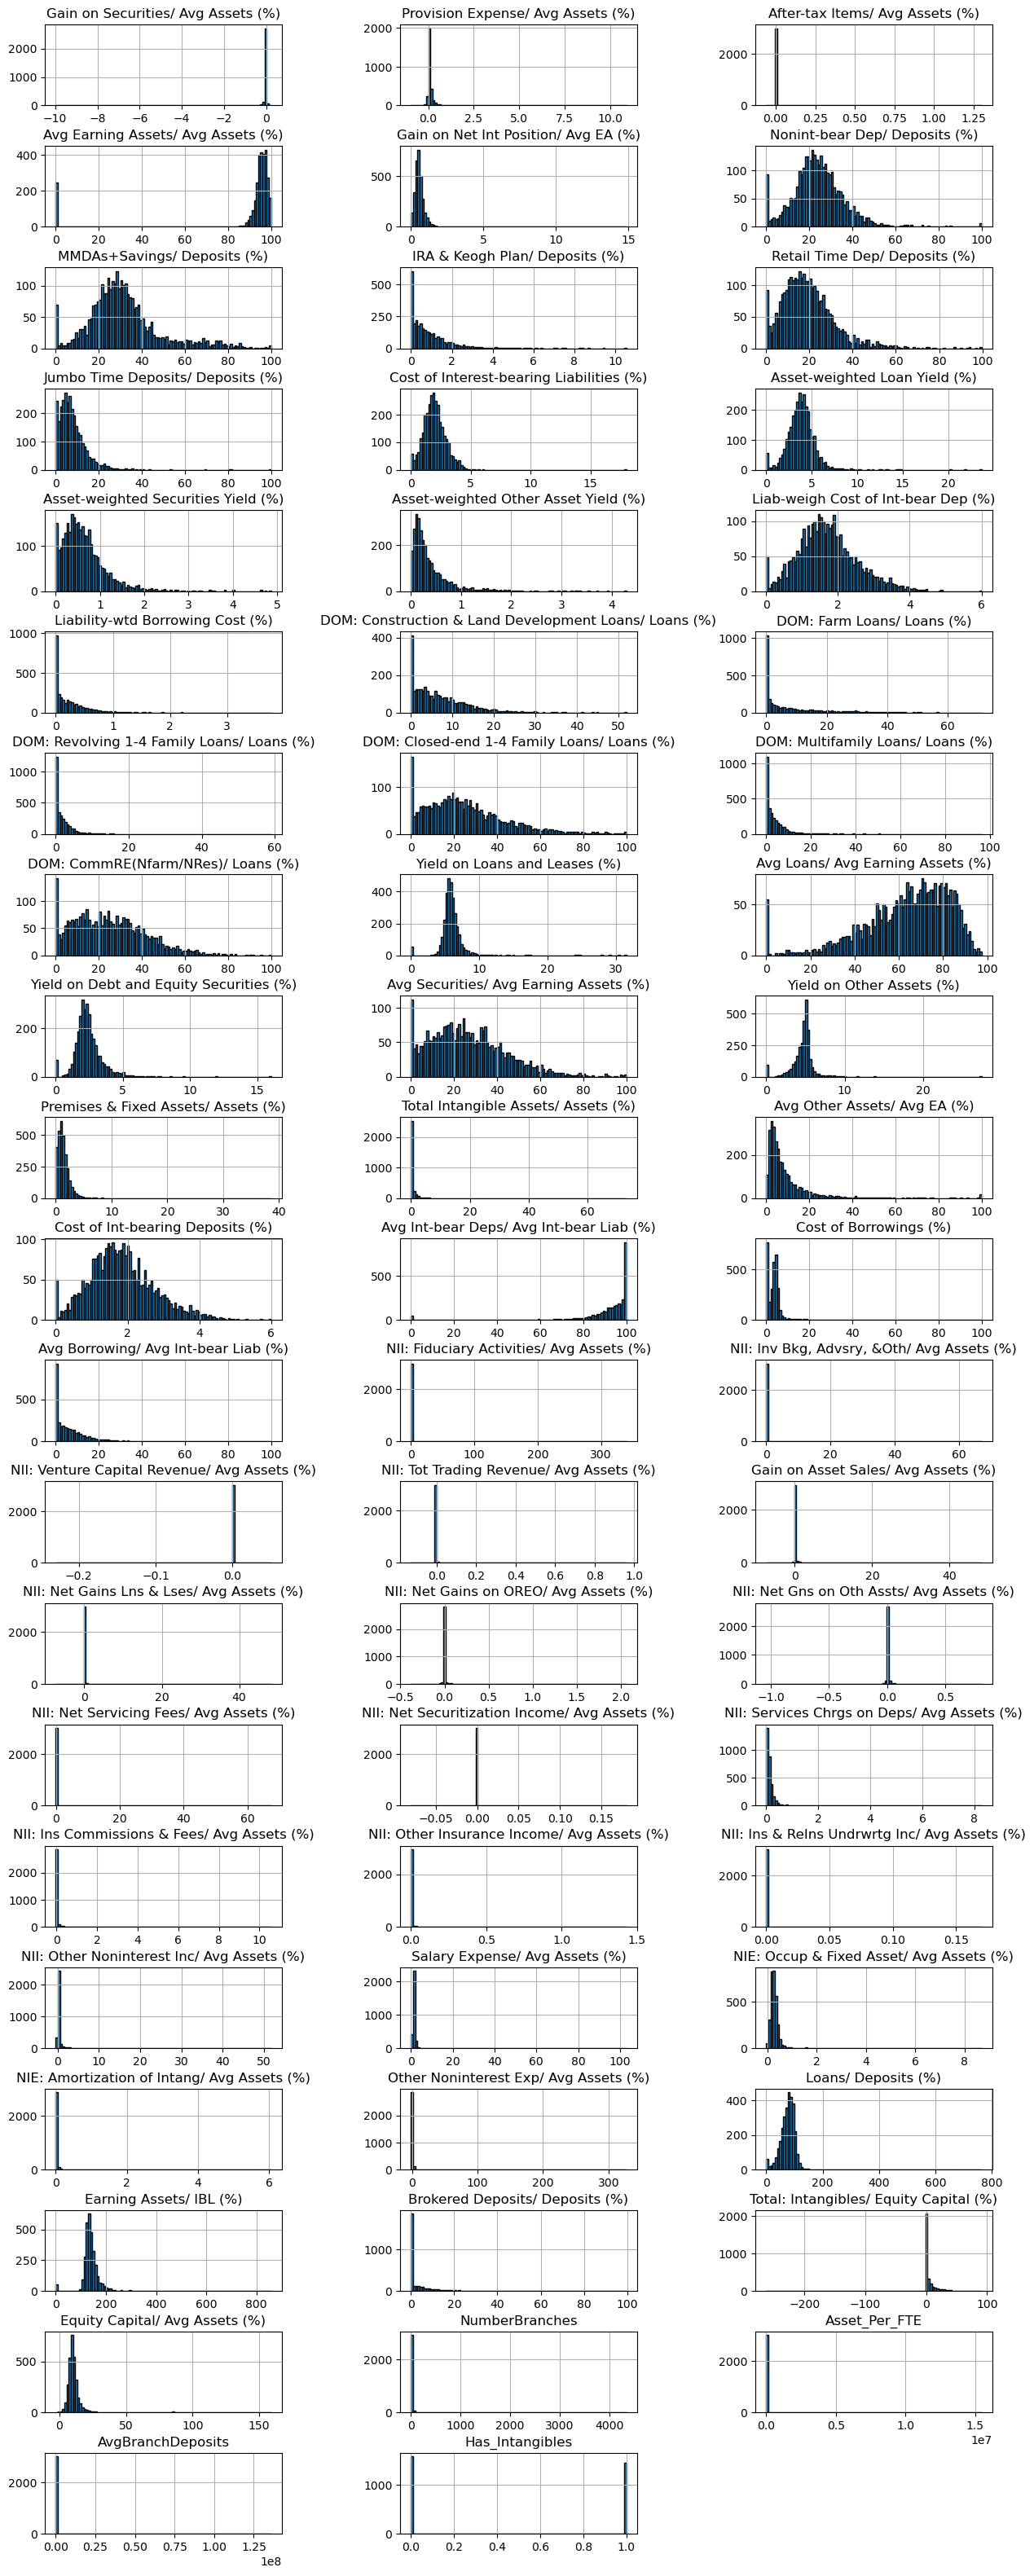

In [560]:
X.hist(figsize=(15, 40), bins=100, layout=(-1, 3), edgecolor='black')
plt.subplots_adjust(hspace=.5, wspace=.5)
plt.show()

## Perform OneHotEncoding on Labels

In [561]:
# Perform OnehotEncoding on object columns

cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# cat_cols

col_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessed = ColumnTransformer(
                                  transformers=[('cat', col_transformer, cat_cols)], remainder='passthrough'      
                                )

X_transformed = preprocessed.fit_transform(X)

X_transformed = pd.DataFrame(X_transformed, columns=preprocessed.get_feature_names_out())

# Optionally, you can display the DataFrame to verify its structure
X_transformed.head()

,cat__De Novo Bank? Yes/No_No,cat__De Novo Bank? Yes/No_Yes,remainder__Gain on Securities/ Avg Assets (%),remainder__Provision Expense/ Avg Assets (%),remainder__After-tax Items/ Avg Assets (%),remainder__Avg Earning Assets/ Avg Assets (%),remainder__Gain on Net Int Position/ Avg EA (%),remainder__Nonint-bear Dep/ Deposits (%),remainder__MMDAs+Savings/ Deposits (%),remainder__IRA & Keogh Plan/ Deposits (%),remainder__Retail Time Dep/ Deposits (%),remainder__Jumbo Time Deposits/ Deposits (%),remainder__Cost of Interest-bearing Liabilities (%),remainder__Asset-weighted Loan Yield (%),remainder__Asset-weighted Securities Yield (%),remainder__Asset-weighted Other Asset Yield (%),remainder__Liab-weigh Cost of Int-bear Dep (%),remainder__Liability-wtd Borrowing Cost (%),remainder__DOM: Construction & Land Development Loans/ Loans (%),remainder__DOM: Farm Loans/ Loans (%),remainder__DOM: Revolving 1-4 Family Loans/ Loans (%),remainder__DOM: Closed-end 1-4 Family Loans/ Loans (%),remainder__DOM: Multifamily Loans/ Loans (%),remainder__DOM: CommRE(Nfarm/NRes)/ Loans (%),remainder__Yield on Loans and Leases (%),remainder__Avg Loans/ Avg Earning Assets (%),remainder__Yield on Debt and Equity Securities (%),remainder__Avg Securities/ Avg Earning Assets (%),remainder__Yield on Other Assets (%),remainder__Premises & Fixed Assets/ Assets (%),remainder__Total Intangible Assets/ Assets (%),remainder__Avg Other Assets/ Avg EA (%),remainder__Cost of Int-bearing Deposits (%),remainder__Avg Int-bear Deps/ Avg Int-bear Liab (%),remainder__Cost of Borrowings (%),remainder__Avg Borrowing/ Avg Int-bear Liab (%),remainder__NII: Fiduciary Activities/ Avg Assets (%),"remainder__NII: Inv Bkg, Advsry, &Oth/ Avg Assets (%)",remainder__NII: Venture Capital Revenue/ Avg Assets (%),remainder__NII: Tot Trading Revenue/ Avg Assets (%),remainder__Gain on Asset Sales/ Avg Assets (%),remainder__NII: Net Gains Lns & Lses/ Avg Assets (%),remainder__NII: Net Gains on OREO/ Avg Assets (%),remainder__NII: Net Gns on Oth Assts/ Avg Assets (%),remainder__NII: Net Servicing Fees/ Avg Assets (%),remainder__NII: Net Securitization Income/ Avg Assets (%),remainder__NII: Services Chrgs on Deps/ Avg Assets (%),remainder__NII: Ins Commissions & Fees/ Avg Assets (%),remainder__NII: Other Insurance Income/ Avg Assets (%),remainder__NII: Ins & ReIns Undrwrtg Inc/ Avg Assets (%),remainder__NII: Other Noninterest Inc/ Avg Assets (%),remainder__Salary Expense/ Avg Assets (%),remainder__NIE: Occup & Fixed Asset/ Avg Assets (%),remainder__NIE: Amortization of Intang/ Avg Assets (%),remainder__Other Noninterest Exp/ Avg Assets (%),remainder__Loans/ Deposits (%),remainder__Earning Assets/ IBL (%),remainder__Brokered Deposits/ Deposits (%),remainder__Total: Intangibles/ Equity Capital (%),remainder__Equity Capital/ Avg Assets (%),remainder__NumberBranches,remainder__Asset_Per_FTE,remainder__AvgBranchDeposits,remainder__Has_Intangibles
0,1.0,0.0,0.00,0.06,0.0,92.89,0.40,17.56,18.87,0.8236,17.32,9.59,1.98,2.7589,0.7674,0.2316,1.69,0.29,1.21,32.11,2.14,9.94,1.89,23.83,5.23,52.79,1.8561,41.35,3.95,0.66,0.11,5.86,1.80,94.08,4.90,5.92,0.04,0.01,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.16,0.85,0.16,0.06,0.62,67.58,122.59,0.0,1.57,7.28,4.0,9243.937500,48741.000000,1.0
1,0.0,1.0,0.00,0.09,0.0,98.21,0.83,30.28,26.01,1.0362,24.23,13.73,2.06,4.8092,0.0405,0.4169,1.97,0.09,3.20,1.38,1.15,8.52,3.16,66.25,5.33,90.25,3.6787,1.10,4.82,1.46,0.00,8.65,2.04,96.74,2.61,3.26,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.13,1.78,0.24,0.00,0.86,104.57,157.72,0.0,0.00,10.89,1.0,6915.954545,64716.000000,0.0
2,1.0,0.0,-0.10,0.08,0.0,95.88,0.31,27.16,21.93,1.4966,26.25,9.04,1.04,2.7812,0.6383,0.1913,1.03,0.01,4.18,3.77,0.00,19.42,0.00,16.86,7.40,37.60,1.4455,44.16,1.05,1.10,0.00,18.25,1.04,98.93,0.93,1.07,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.26,0.0,0.0,0.0,0.19,1.41,0.33,0.00,0.97,41.62,137.89,0.0,0.00,5.68,1.0,3320.769231,20575.500000,0.0
3,1.0,0.0,0.00,-0.01,0.0,93.81,0.28,26.3

In [562]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.30, random_state=42)

## Decision Tree

In [563]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [100, 150, 250, 500],
    'min_samples_leaf': [50, 75, 100, 150, 250],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [564]:
tree = DecisionTreeClassifier()

In [565]:
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='accuracy')

In [566]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [50, 75, 100, 150, 250],
                         'min_samples_split': [100, 150, 250, 500]},
             scoring='accuracy')

In [567]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 75, 'min_samples_split': 250}


In [568]:
dt_results = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score', ascending=True)
dt_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
446,0.005001,0.000631,0.000999,0.000003,entropy,6,sqrt,75,250,"{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 75, 'min_samples_split': 250}",0.668235,0.661176,0.640000,0.632075,0.641509,0.648599,0.013719,1
391,0.004600,0.000490,0.001200,0.000399,entropy,5,sqrt,100,500,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 100, 'min_samples_split': 500}",0.644706,0.647059,0.649412,0.622642,0.658019,0.644367,0.011757,2
161,0.003601,0.000490,0.001199,0.000400,gini,5,log2,50,150,"{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 50, 'min_samples_split': 150}",0.640000,0.672941,0.623529,0.603774,0.665094,0.641068,0.025662,3
372,0.004400,0.000490,0.001000,0.000001,entropy,5,auto,150,100,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 150, 'min_samples_split': 100}",0.616471,0.680000,0.623529,0.629717,0.648585,0.639660,0.022820,4
195,0.003799,0.000399,0.001000,0.000001,gini,6,auto,150,500,"{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 150, 'min_samples_split': 500}",0.649412,0.654118,0.663529,0.648585,0.582547,0.639638,0.029036,5


In [569]:
best_dt = grid_search.best_estimator_

In [570]:
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
y_pred = best_dt.predict(X_test)
print("Test accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

Best cross-validation score: 0.65
Test accuracy: 0.64


In [571]:
results = pd.DataFrame(grid_search.cv_results_)

In [572]:
y_pred = best_dt.predict(X_test)
print("\n","Test accuracy:", accuracy_score(y_test, y_pred),'\n')

print("Classification Report:\n", classification_report(y_test, y_pred))


 Test accuracy: 0.6395604395604395 

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.69      0.66       470
           1       0.64      0.58      0.61       440

    accuracy                           0.64       910
   macro avg       0.64      0.64      0.64       910
weighted avg       0.64      0.64      0.64       910



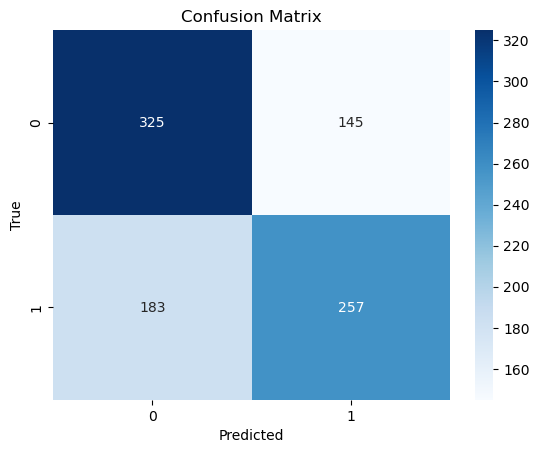

In [573]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

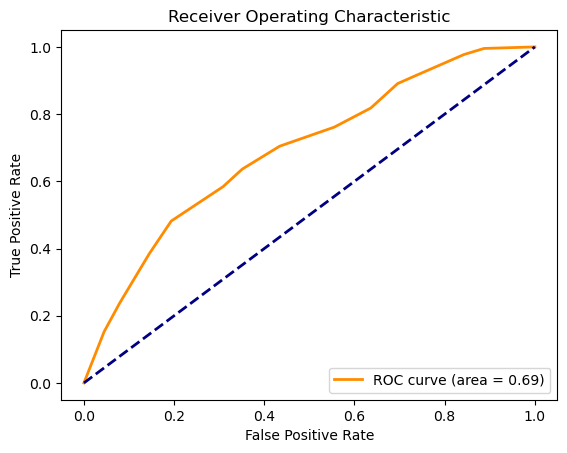

In [574]:
fpr, tpr, thresholds = roc_curve(y_test, best_dt.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [575]:
feature_names = [name.replace('&', '').replace('<', '').replace('>', '').replace(' ', '') for name in X_train.columns]
# feature_names

In [576]:
dot_data = export_graphviz(best_dt, out_file=None,
                           feature_names=feature_names,  
                           class_names=["ROELess12", "ROEGreater12"],  # Adjust class names as necessary
                           filled=True, rounded=True,
                           special_characters=True)

In [577]:
graph = graphviz.Source(dot_data)


In [578]:
graph.render("decision_tree", format='png', cleanup=True)

'decision_tree.png'

## LOGISTIC REGRESSION

In [579]:
y.value_counts(normalize=True)

0    0.543027
1    0.456973
Name: ROE_12%, dtype: float64

In [580]:
l_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
])

In [581]:
# ran poly degree 1 and 2 and non-linearity did not make a difference.

l_param_grid = {
    'poly__degree': [1],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 250],
    'classifier__penalty': ['l2']
}

In [582]:
l_grid_search = GridSearchCV(l_pipeline, l_param_grid, cv=5, scoring='accuracy')

In [583]:
l_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 250],
                         'classifier__penalty': ['l2'], 'poly__degree': [1]},
             scoring='accuracy')

In [584]:
print("Best parameters:", l_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(l_grid_search.best_score_))
print("Test-set score: {:.2f}".format(l_grid_search.score(X_test, y_test)))

Best parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'poly__degree': 1}
Best cross-validation score: 0.89
Test-set score: 0.91


In [585]:
l_best_model = l_grid_search.best_estimator_

In [586]:
l_results = pd.DataFrame(l_grid_search.cv_results_).sort_values('rank_test_score', ascending=True)
l_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.219800,0.032904,0.001599,0.000490,100,l2,1,"{'classifier__C': 100, 'classifier__penalty': 'l2', 'poly__degree': 1}",0.915294,0.905882,0.865882,0.870283,0.908019,0.893072,0.020688,1
6,0.265399,0.024525,0.002199,0.000401,250,l2,1,"{'classifier__C': 250, 'classifier__penalty': 'l2', 'poly__degree': 1}",0.905882,0.903529,0.877647,0.865566,0.910377,0.892600,0.017699,2
4,0.099001,0.013401,0.001999,0.000633,10,l2,1,"{'classifier__C': 10, 'classifier__penalty': 'l2', 'poly__degree': 1}",0.903529,0.901176,0.849412,0.827830,0.896226,0.875635,0.031072,3
3,0.034000,0.004001,0.001799,0.000399,1,l2,1,"{'classifier__C': 1, 'classifier__penalty': 'l2', 'poly__degree': 1}",0.832941,0.842353,0.795294,0.754717,0.823113,0.809684,0.031676,4
2,0.017399,0.000491,0.001201,0.000400,0.1,l2,1,"{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'poly__degree': 1}",0.783529,0.738824,0.752941,0.709906,0.768868,0.750814,0.025369,5


## Classification Report

#### Classification Report Metrics

##### Precision: This metric tells you what percentage of the predicted positive cases were actually positive.

###### Class 0 (ROE Less Than 12%): 0.92
This means that when the model predicted a sample to be in class 0, it was correct 92% of the time.
###### Class 1 (ROE Greater Than or Equal to 12%): 0.91
This means that when the model predicted a sample to be in class 1, it was correct 91% of the time.
##### Recall: This metric tells you what percentage of actual positive cases were correctly identified by the model.
###### Class 0 (ROE Less Than 12%):  
This means that out of all actual class 0 samples, the model correctly identified 92% of them.
###### Class 1 (ROE Greater Than or Equal to 12%):  
This means that out of all actual class 1 samples, the model correctly identified 91% of them
###### ROC AUC Score: 0.914
The ROC AUC (Receiver Operating Characteristic Area Under the Curve) score measures the ability of the model to distinguish between the two classes. A score of 0.914 indicates a high level of discrimination, meaning the model is very good at distinguishing between the positive and negative classes.


In [587]:
l_y_pred = l_best_model.predict(X_test)
print('\n',"Classification Report:\n", classification_report(y_test, l_y_pred), '\n')
print("ROC AUC Score:", roc_auc_score(y_test, l_y_pred))


 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       470
           1       0.91      0.91      0.91       440

    accuracy                           0.91       910
   macro avg       0.91      0.91      0.91       910
weighted avg       0.91      0.91      0.91       910
 

ROC AUC Score: 0.914119922630561


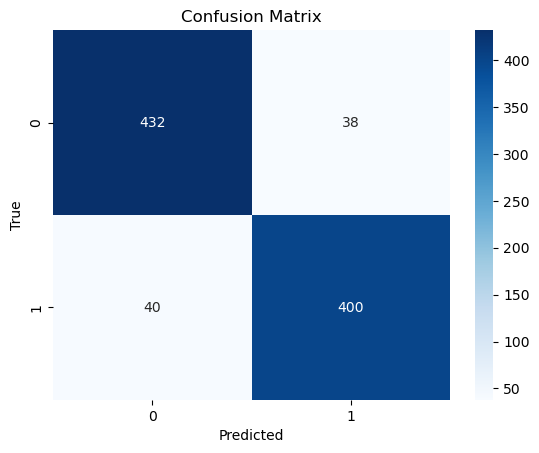

In [588]:
l_cm = confusion_matrix(y_test, l_y_pred)
sns.heatmap(l_cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

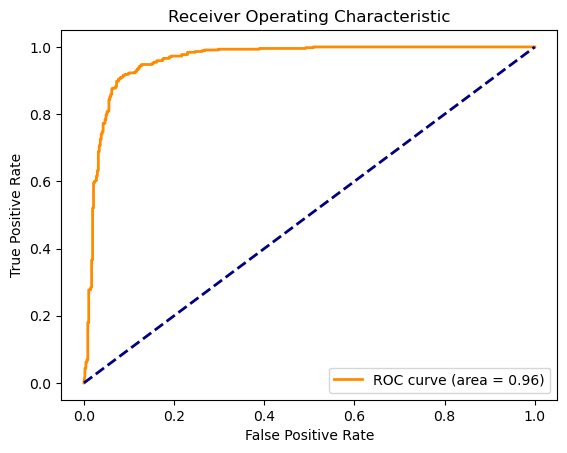

In [589]:
fpr, tpr, thresholds = roc_curve(y_test, l_best_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Features Importances

#### How to Interpret These Coefficients

Coefficient: Indicates the direction and strength of the feature's impact on the prediction. A positive coefficient means that as the feature value increases, the prediction also increases. Conversely, a negative coefficient means that as the feature value increases, the prediction decreases.

Absolute Coefficient: This represents the magnitude of the feature’s impact without considering the direction. It helps in understanding which features are most influential overall.

#### Importance in Decision-Making

Top Influencers: Features with the highest absolute coefficients (e.g., NII: Fiduciary Activities/ Avg Assets (%) and Other Noninterest Exp/ Avg Assets (%)) are the most critical for the model. These are the features that most significantly drive the predictions.

Moderate Influencers: Features with moderate absolute coefficients (e.g., Salary Expense/ Avg Assets (%), NII: Inv Bkg, Advsry, & Oth/ Avg Assets (%)) have noticeable but less dominant effects on the model’s output.

I was actually surprised by the results as initially hypothesized that the level of intangible assets a bank held would be a strong influencer, but the data proves otherwise.  

Leveraging staff, managing other non-specific expenses, and increasing revenue from fiduciary activities that require little capital have the biggest impact on the overall predictability of return on equity.

In [590]:
l_feature_names = l_best_model.named_steps['poly'].get_feature_names_out(input_features=X_train.columns)
coefficients = l_best_model.named_steps['classifier'].coef_[0] 

In [591]:
feature_importance = pd.DataFrame({
    'Feature': l_feature_names,
    'Coefficient': coefficients
})

# Sorting the features by the absolute values of their coefficients in descending order
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
feature_importance.head(15)

,Feature,Coefficient,Absolute Coefficient
37,remainder__NII: Fiduciary Activities/ Avg Assets (%),78.964178,78.964178
55,remainder__Other Noninterest Exp/ Avg Assets (%),-61.884181,61.884181
52,remainder__Salary Expense/ Avg Assets (%),-20.747579,20.747579
51,remainder__NII: Other Noninterest Inc/ Avg Assets (%),11.932819,11.932819
60,remainder__Equity Capital/ Avg Assets (%),-10.665236,10.665236
13,remainder__Cost of Interest-bearing Liabilities (%),-10.077967,10.077967
14,remainder__Asset-weighted Loan Yield (%),9.541456,9.541456
45,remainder__NII: Net Servicing Fees/ Avg Assets (%),7.984252,7.984252
41,remainder__Gain on Asset Sales/ Avg Assets (%),5.927861,5.927861
17,remainder__Liab-weigh Cost of Int-bear Dep (%),5.087662,5.087662


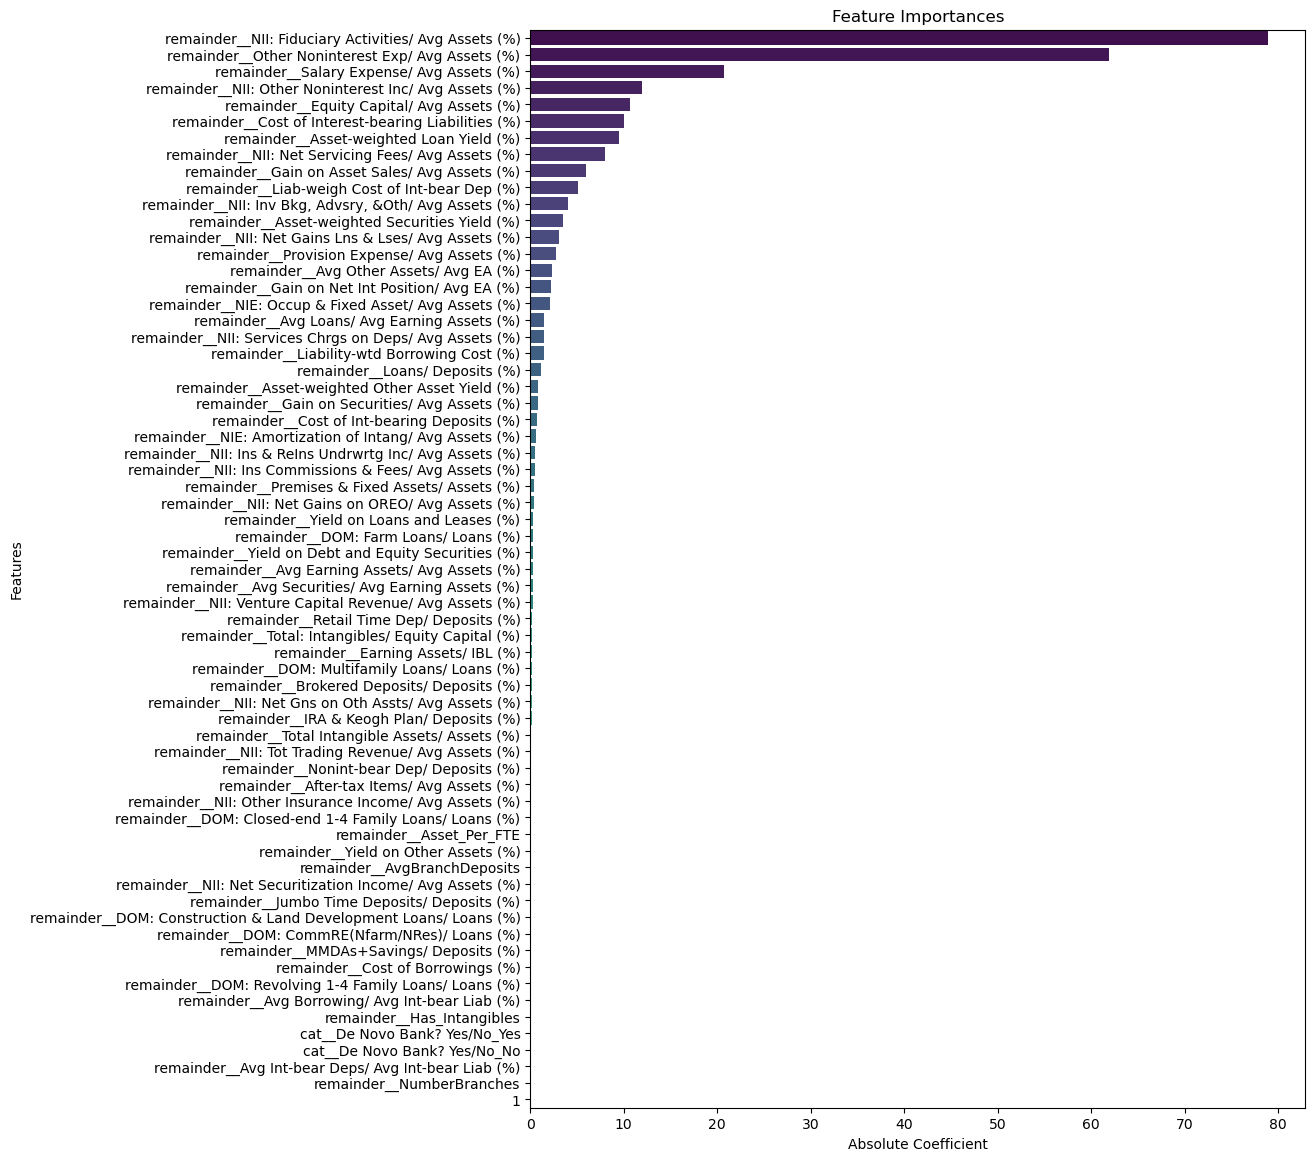

In [592]:
plt.figure(figsize=(10, 14))
sns.barplot(x='Absolute Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Features')

plt.show()

In [593]:
# X_transformed[(X_transformed['remainder__AvgBranchDeposits'] >= 48471) & 
#                             (X_transformed['remainder__AvgBranchDeposits'] <= 48472)]

fcbc = X_transformed.iloc[X[(X['AvgBranchDeposits'] > 48471) & (X['AvgBranchDeposits'] < 48472)].index[0]].to_dict()
fcbc

{'cat__De Novo Bank? Yes/No_No': 1.0,
 'cat__De Novo Bank? Yes/No_Yes': 0.0,
 'remainder__Gain on Securities/ Avg Assets (%)': 0.0,
 'remainder__Provision Expense/ Avg Assets (%)': 0.26,
 'remainder__After-tax Items/ Avg Assets (%)': 0.0,
 'remainder__Avg Earning Assets/ Avg Assets (%)': 89.04,
 'remainder__Gain on Net Int Position/ Avg EA (%)': 0.2,
 'remainder__Nonint-bear Dep/ Deposits (%)': 34.05,
 'remainder__MMDAs+Savings/ Deposits (%)': 55.52,
 'remainder__IRA & Keogh Plan/ Deposits (%)': 0.9204,
 'remainder__Retail Time Dep/ Deposits (%)': 8.55,
 'remainder__Jumbo Time Deposits/ Deposits (%)': 0.68,
 'remainder__Cost of Interest-bearing Liabilities (%)': 0.53,
 'remainder__Asset-weighted Loan Yield (%)': 4.3903,
 'remainder__Asset-weighted Securities Yield (%)': 0.2331,
 'remainder__Asset-weighted Other Asset Yield (%)': 0.1113,
 'remainder__Liab-weigh Cost of Int-bear Dep (%)': 0.52,
 'remainder__Liability-wtd Borrowing Cost (%)': 0.01,
 'remainder__DOM: Construction & Land De

## Changing Feature Variables to Predict ROE Using Logistic Regression Predictor

The data shows that these 3 ratios have the highest influence in predicting the Return on Equity.  Changing any one of these better by .17 will result in the predicted ROE of FCBC being greater than 12%.

In [624]:
fcbc['remainder__Salary Expense/ Avg Assets (%)'] = 1.53            # original value 1.53
fcbc['remainder__NII: Fiduciary Activities/ Avg Assets (%)'] = .07  # original value  .07
fcbc['remainder__Other Noninterest Exp/ Avg Assets (%)'] = 1.06      # original value 1.06

fcbc_prediction = np.array(list(fcbc.values())).reshape(1,-1)

In [625]:
l_best_model.predict(fcbc_prediction)

C:\Users\mastull\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

## Support Vector Classifier

In [596]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the pipeline with SVM
svm_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

# Define the parameter grid for grid search
svm_param_grid = {
    'poly__degree': [1],  # Polynomial degree
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 250],  # Regularization parameter
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient
}

# Set up the grid search with cross-validation
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
svm_grid_search.fit(X_train, y_train)

# Display the best parameters and the corresponding accuracy
print(f"Best parameters: {svm_grid_search.best_params_}")
print(f"Best cross-validation accuracy: {svm_grid_search.best_score_:.4f}")

Best parameters: {'classifier__C': 100, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'poly__degree': 1}
Best cross-validation accuracy: 0.8973


In [597]:
svm_results = pd.DataFrame(svm_grid_search.cv_results_).sort_values('rank_test_score', ascending=True)
svm_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,param_classifier__kernel,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,9.783346,0.399328,0.006201,0.000400,100,scale,linear,1,"{'classifier__C': 100, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'poly__degree': 1}",0.915294,0.905882,0.875294,0.872642,0.917453,0.897313,0.019472,1
44,9.699948,0.263289,0.006200,0.000399,100,auto,linear,1,"{'classifier__C': 100, 'classifier__gamma': 'auto', 'classifier__kernel': 'linear', 'poly__degree': 1}",0.915294,0.905882,0.875294,0.872642,0.917453,0.897313,0.019472,1
52,22.855278,4.671509,0.006207,0.000396,250,auto,linear,1,"{'classifier__C': 250, 'classifier__gamma': 'auto', 'classifier__kernel': 'linear', 'poly__degree': 1}",0.903529,0.901176,0.870588,0.872642,0.910377,0.891663,0.016658,3
48,22.490291,4.628200,0.006022,0.000646,250,scale,linear,1,"{'classifier__C': 250, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'poly__degree': 1}",0.903529,0.901176,0.870588,0.872642,0.910377,0.891663,0.016658,3
36,1.420397,0.156819,0.009016,0.001094,10,auto,linear,1,"{'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'linear', 'poly__degree': 1}",0.912941,0.896471,0.858824,0.853774,0.903302,0.885062,0.024114,5


In [598]:
svm_y_pred = l_best_model.predict(X_test)
print('\n',"Classification Report:\n", classification_report(y_test, svm_y_pred), '\n')
print("ROC AUC Score:", roc_auc_score(y_test, svm_y_pred))


 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       470
           1       0.91      0.91      0.91       440

    accuracy                           0.91       910
   macro avg       0.91      0.91      0.91       910
weighted avg       0.91      0.91      0.91       910
 

ROC AUC Score: 0.914119922630561


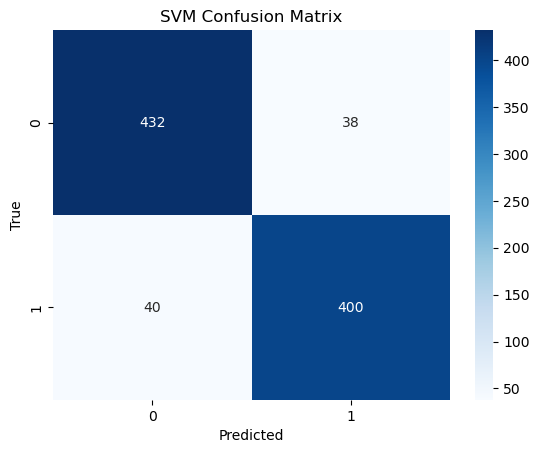

In [599]:
svm_cm = confusion_matrix(y_test, svm_y_pred)
sns.heatmap(l_cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()

In [600]:
# Get the best pipeline from the GridSearchCV
best_pipeline = svm_grid_search.best_estimator_

# Get feature names from PolynomialFeatures
svm_feature_names = best_pipeline.named_steps['poly'].get_feature_names_out(input_features=X_train.columns)


In [601]:
svm_feature_importance = pd.DataFrame({
    'Feature': svm_feature_names,
    'Coefficient': coefficients
})

# Sorting the features by the absolute values of their coefficients in descending order
svm_feature_importance['Absolute Coefficient'] = svm_feature_importance['Coefficient'].abs()
svm_feature_importance = svm_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
svm_feature_importance.head(15)

,Feature,Coefficient,Absolute Coefficient
37,remainder__NII: Fiduciary Activities/ Avg Assets (%),78.964178,78.964178
55,remainder__Other Noninterest Exp/ Avg Assets (%),-61.884181,61.884181
52,remainder__Salary Expense/ Avg Assets (%),-20.747579,20.747579
51,remainder__NII: Other Noninterest Inc/ Avg Assets (%),11.932819,11.932819
60,remainder__Equity Capital/ Avg Assets (%),-10.665236,10.665236
13,remainder__Cost of Interest-bearing Liabilities (%),-10.077967,10.077967
14,remainder__Asset-weighted Loan Yield (%),9.541456,9.541456
45,remainder__NII: Net Servicing Fees/ Avg Assets (%),7.984252,7.984252
41,remainder__Gain on Asset Sales/ Avg Assets (%),5.927861,5.927861
17,remainder__Liab-weigh Cost of Int-bear Dep (%),5.087662,5.087662


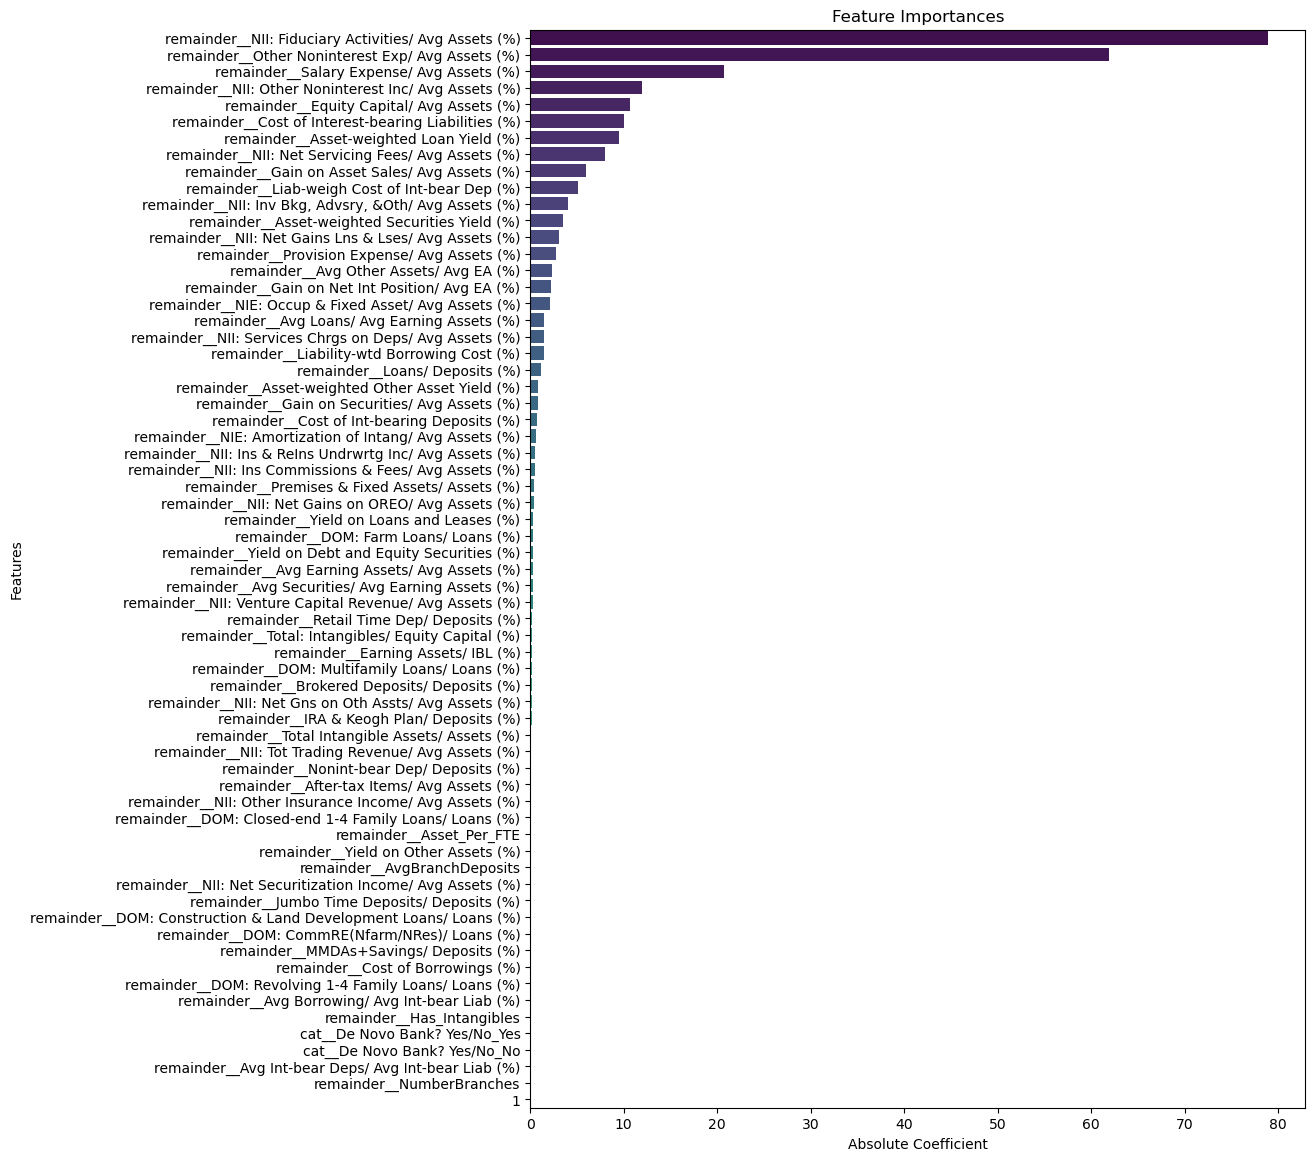

In [602]:
plt.figure(figsize=(10, 14))
sns.barplot(x='Absolute Coefficient', y='Feature', data=svm_feature_importance, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Features')

plt.show()

## Model Results Comparison

Based on the results, both Logistic Regression and the Support Vector Classifier are excellent choices, achieving nearly identical and high accuracy rates of 89%. The Decision Tree, while useful for understanding feature importance and interpretability, performed significantly worse with an accuracy of 64%.

In [603]:
model_results = {
                    'Model Name': ['Decision Tree', 'Logistic Regression', 'Support Vector Classifier'],
                    'Best Params': [grid_search.best_params_, l_grid_search.best_params_, svm_grid_search.best_params_],
                    'Accuracy': [grid_search.best_score_, l_grid_search.best_score_, svm_grid_search.best_score_]
                
                }

final_model_results = pd.DataFrame(model_results)
final_model_results

,Model Name,Best Params,Accuracy
0,Decision Tree,"{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 75, 'min_samples_split': 250}",0.648599
1,Logistic Regression,"{'classifier__C': 100, 'classifier__penalty': 'l2', 'poly__degree': 1}",0.893072
2,Support Vector Classifier,"{'classifier__C': 100, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'poly__degree': 1}",0.897313


## Next Steps and Further Investigation

As mentioned earlier, feature importances showed Fiduciary Activities, Other Non-Interest Expense and Salaries (all 3 as a percentage of assets) having the strongest influence to predicting an ROE greater than 12%.  Fiduciary Activity revenue is generated by expanding services such as Trust and Wealth Management Advisory.  Other Non-Interest Expense is often-times by one-time items.  Other ratios that are part of this analysis, however, can be used to identify areas causing salaries expense to assets to be higher.  The logistic regression model predicts a .03 improvement in one of the 3 ratios above to generate an ROE of 12%.

As a result, two additional decision trees were ran to help determine other areas the bank should focus on to help improve ROE.

The first decision tree had a targeted (y-value) salaries to expense ratio of 1.50%, which is .03% better than FCBC's 1.53%.  This decision tree had an accuracy of 72%.  This tree predicts to generate a Salaries Expense / Asset ratio of 1.50% or better, Occupancy & Fixed Asset Expense / Assets needs to be better than .245%.  FCBC's ratio is .34%.  The tree also predicts if Occupancy & Fixed Asset Expense / Assets is higher than .245%, a Salaries Expense / Asset ratio of 1.50% or better can be achieved ultimately with average branch deposits greater than 39 million.  First Community has an average branch deposit of 48 million.  This would suggest the occupancy expense of the branch or average branch size increasing could help improve profitability.

https://github.com/MattStull/Berkeley_Machine_Learning_Capstone_24/blob/main/decision_tree_salariesexp.png

Further, an additional decision tree was ran on banks that generated Occupancy & Fixed Asset Expense / Asset ratios of .31% or better.  FCBC's ratio is .34%.  This was the target for the decision tree.  The accuracy score of this decision tree was 77%.  This tree predominantly predicted Fixed Asset to Asset ratios needed to be less than 1.53% to achieve the target Occupancy & Fixed Asset Expense / Asset ratio of .31% or better.  The Fixed Asset to Asset ratio for FCBC is 1.56%.  A branch of banks, however, did achieve a Fixed Asset Expense / Asset ratio of .31% or better if Fixed Assets / Assets were higher than 1.53%.  This was achieved generally by having an Assets / FTE (full time equivalent employee) ratio of 6 million or greater.  FCBC's Assets / FTE ratio of 5.2 million.

https://github.com/MattStull/Berkeley_Machine_Learning_Capstone_24/blob/main/decision_tree_occ_exp.png

Given the average branch deposits in a range that is acceptable, this would suggest non-earning assets or corporate employee levels are at inefficient levels and focus should be on these areas to improve profitability.